# Install packages

In [1]:
%%capture
!pip install torchinfo

# Import libraries

In [2]:
# Data Handling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Preprocessing
from sklearn.model_selection import train_test_split

# Torch
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchinfo import summary
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

# OrderedDict
from collections import OrderedDict

# random
import random

# warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load data and EDA

In [3]:
IMAGE_PATH = Path("/kaggle/input/monkey-species-image-final")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*.jpg"))

print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 9626


In [4]:
classes = os.listdir(IMAGE_PATH)
classes = sorted(classes)

print('==' * 20)
print(' ' * 10, f'Total Classes = {len(classes)}')
print('==' * 20)
for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH,c)).glob("*.jpg"))
    print(f'* {c}: {len(total_images_class)} images')


           Total Classes = 10
* bald_uakari: 942 images
* emperor_tamarin: 968 images
* golden_monkey: 978 images
* gray_langur: 956 images
* hamadryas_baboon: 926 images
* mandril: 951 images
* proboscis_monkey: 984 images
* red_howler: 983 images
* vervet_monkey: 973 images
* white_faced_saki: 965 images


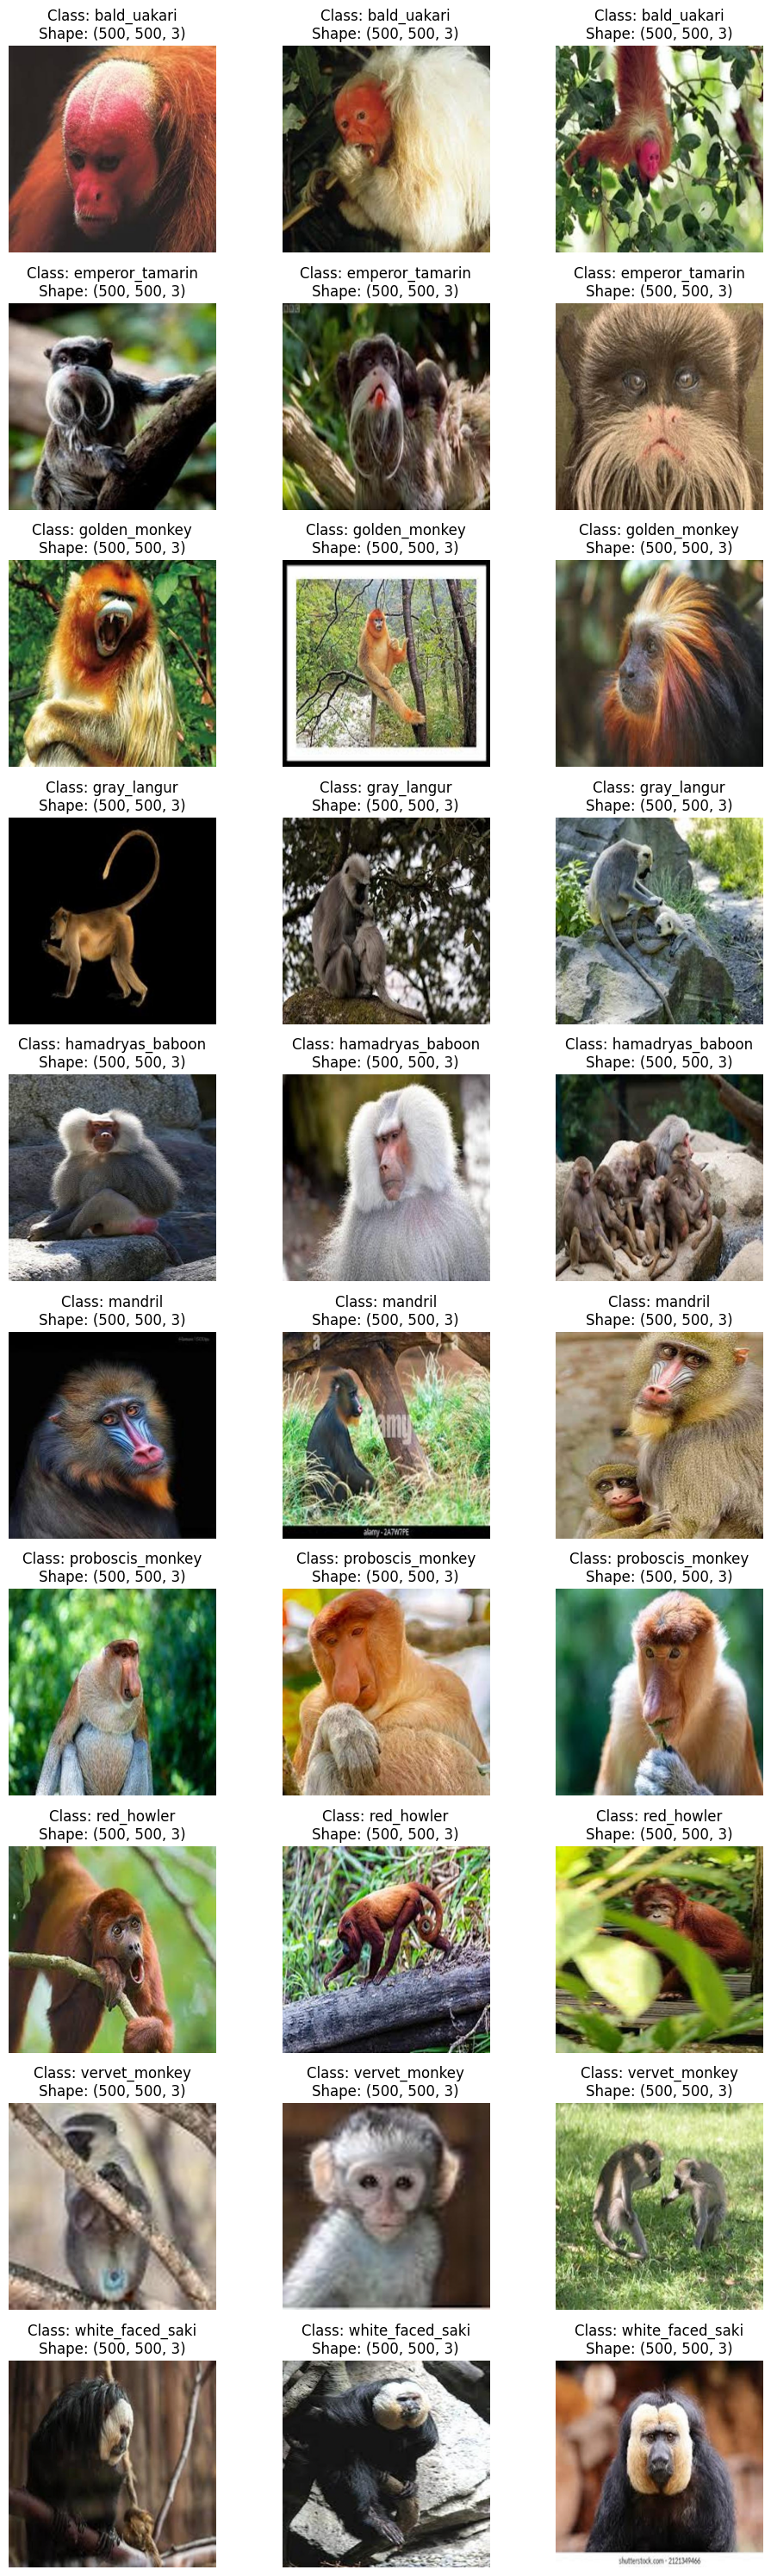

In [5]:
NUM_IMAGES = 3

fig,ax = plt.subplots(nrows = len(classes), ncols = NUM_IMAGES, figsize = (10,30))
p = 0
for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH,c)).glob("*.jpg"))
    images_selected = random.choices(total_images_class, k = NUM_IMAGES)
    
    for i,img_path in enumerate(images_selected):
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].axis('off')
        ax[p,i].set_title(f'Class: {c}\nShape: {img_rgb.shape}')
        
    p += 1
    
fig.tight_layout()
fig.show()

# Image Preprocessing

In [6]:
images_path = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i,img_path in enumerate(IMAGE_PATH_LIST):
    images_path[i] = img_path
    labels[i] = img_path.parent.stem
    
df_path_and_label = pd.DataFrame({'path':images_path, 
                                  'label':labels})

df_path_and_label.head()

path             label
0  /kaggle/input/monkey-species-image-final/white...  white_faced_saki
1  /kaggle/input/monkey-species-image-final/white...  white_faced_saki
2  /kaggle/input/monkey-species-image-final/white...  white_faced_saki
3  /kaggle/input/monkey-species-image-final/white...  white_faced_saki
4  /kaggle/input/monkey-species-image-final/white...  white_faced_saki

- **train = 70%**
- **validation = 15%**
- **test = 15%**

In [7]:
SEED = 42

df_train, df_rest = train_test_split(df_path_and_label, test_size = 0.3, 
                                     random_state = SEED, stratify = df_path_and_label["label"])

df_valid, df_test = train_test_split(df_rest, test_size = 0.5, 
                                     random_state = SEED, stratify = df_rest["label"])

In [8]:
# Print the total number of images in each set
print(f'Total Images: {len(IMAGE_PATH_LIST)}')
print(f'Total Training Images: {len(df_train)}')
print(f'Total Validation Images: {len(df_valid)}')
print(f'Total Test Images: {len(df_test)}')

# Print the number of images by class in each set
print('\nTrain Set:')
for c in classes:
    total_images_class = df_train[df_train["label"] == c]
    print(f'* {c}: {len(total_images_class)} images')

print('\nValidation Set:')
for c in classes:
    total_images_class = df_valid[df_valid["label"] == c]
    print(f'* {c}: {len(total_images_class)} images')

print('\nTest Set:')
for c in classes:
    total_images_class = df_test[df_test["label"] == c]
    print(f'* {c}: {len(total_images_class)} images')

Total Images: 9626
Total Training Images: 6738
Total Validation Images: 1444
Total Test Images: 1444

Train Set:
* bald_uakari: 659 images
* emperor_tamarin: 678 images
* golden_monkey: 685 images
* gray_langur: 669 images
* hamadryas_baboon: 648 images
* mandril: 666 images
* proboscis_monkey: 689 images
* red_howler: 688 images
* vervet_monkey: 681 images
* white_faced_saki: 675 images

Validation Set:
* bald_uakari: 142 images
* emperor_tamarin: 145 images
* golden_monkey: 147 images
* gray_langur: 143 images
* hamadryas_baboon: 139 images
* mandril: 142 images
* proboscis_monkey: 147 images
* red_howler: 148 images
* vervet_monkey: 146 images
* white_faced_saki: 145 images

Test Set:
* bald_uakari: 141 images
* emperor_tamarin: 145 images
* golden_monkey: 146 images
* gray_langur: 144 images
* hamadryas_baboon: 139 images
* mandril: 143 images
* proboscis_monkey: 148 images
* red_howler: 147 images
* vervet_monkey: 146 images
* white_faced_saki: 145 images


In [9]:
# We have to define the mapping of the classes to convert the labels to numbers.
label_map = dict(zip(classes, range(len(classes))))
label_map

{'bald_uakari': 0,
 'emperor_tamarin': 1,
 'golden_monkey': 2,
 'gray_langur': 3,
 'hamadryas_baboon': 4,
 'mandril': 5,
 'proboscis_monkey': 6,
 'red_howler': 7,
 'vervet_monkey': 8,
 'white_faced_saki': 9}

In [10]:
# Now we define the transformations that we are going to apply.
weights = ViT_B_16_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, df:pd.DataFrame, label_map:dict, transforms):
        self.df = df
        self.label_map = label_map
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        df_new = self.df.copy()
        df_new = df_new.reset_index(drop = True)
        df_new["label"] = df_new["label"].map(self.label_map)
        image_path = df_new.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)
        label = df_new.iloc[idx, 1]
        
        return image,label

In [12]:
train_dataset = CustomImageDataset(df_train, label_map, auto_transforms)
valid_dataset = CustomImageDataset(df_valid, label_map, auto_transforms)

In [13]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

valid_dataloader = DataLoader(dataset = valid_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

In [14]:
# Let's visualize the dimensions of a batch.
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# Model

In [15]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
# VIT 16
model = vit_b_16(weights = weights)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 75.2MB/s] 


In [17]:
# Let's visualize the architecture of the model.
summary(model = model, 
        input_size = [32,3,224,224], 
        col_width = 15, 
        col_names = ["input_size", "output_size","num_params","trainable"], 
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 1000]      768             True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] 590,592         True
├─Encoder (encoder)                                          [32, 197, 768]  [32, 197, 768]  151,296         True
│    └─Dropout (dropout)                                     [32, 197, 768]  [32, 197, 768]  --              --
│    └─Sequential (layers)                                   [32, 197, 768]  [32, 197, 768]  --              True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]  [32, 197, 768]  7,087,872       True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]  [32, 197, 768]  7,087,872       True
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768]  [3

In [18]:
for param in model.conv_proj.parameters():
    param.requires_grad = False

In [19]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [20]:
# Let's see if the parameters were frozen.
summary(model = model, 
        input_size = [32,3,224,224], 
        col_width = 15, 
        col_names = ["input_size", "output_size","num_params","trainable"], 
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 1000]      768             Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [32, 197, 768]  [32, 197, 768]  151,296         False
│    └─Dropout (dropout)                                     [32, 197, 768]  [32, 197, 768]  --              --
│    └─Sequential (layers)                                   [32, 197, 768]  [32, 197, 768]  --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 

In [21]:
output_shape = len(classes) # total classes

model.heads = nn.Sequential(OrderedDict([('head', nn.Linear(in_features = 768, 
                                                            out_features = len(classes)))]))

In [22]:
# One last time let's take a look if the last layer was modified.
summary(model = model, 
        input_size = [32,3,224,224], 
        col_width = 15, 
        col_names = ["input_size", "output_size","num_params","trainable"], 
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 10]        768             Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [32, 197, 768]  [32, 197, 768]  151,296         False
│    └─Dropout (dropout)                                     [32, 197, 768]  [32, 197, 768]  --              --
│    └─Sequential (layers)                                   [32, 197, 768]  [32, 197, 768]  --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [24]:
def train_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0.
    train_accuracy = 0.
    
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred_logit = model(X)
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred_class.detach().cpu().numpy())
        
    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(dataloader)
    
    return train_loss, train_accuracy

In [25]:
def save_checkpoint(filename, model, epoch, loss, optimizer, metric):
    state = {'filename':filename, 
             'model':model.state_dict(), 
             'epoch':epoch, 
             'loss':loss, 
             'optimizer':optimizer.state_dict(), 
             'metric':metric}
    
    torch.save(state, filename)

In [26]:
def valid_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module):
    
    model.eval()
    
    valid_loss = 0.
    valid_accuracy = 0.
    
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            y_pred_logit = model(X)
            loss = loss_fn(y_pred_logit, y)
            valid_loss += loss.item()
            
            y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
            y_pred_class = torch.argmax(y_pred_prob, dim = 1)
            valid_accuracy += accuracy_score(y.cpu().numpy(), y_pred_class.detach().cpu().numpy())
            
    valid_loss = valid_loss / len(dataloader)
    valid_accuracy = valid_accuracy / len(dataloader)
    
    return valid_loss, valid_accuracy

In [27]:
def train(model:torch.nn.Module, train_dataloader:torch.utils.data.DataLoader, 
          valid_dataloader:torch.utils.data.DataLoader, loss_fn:torch.nn.Module, 
          optimizer:torch.optim.Optimizer, epochs:int = 10):
    
    results = {"train_loss":[], "train_accuracy":[], "valid_loss":[], "valid_accuracy":[]}
    
    best_valid_loss = float('inf')
    
    for epoch in tqdm(range(epochs)):
        
        train_loss, train_accuracy = train_step(model = model, dataloader = train_dataloader, 
                                                loss_fn = loss_fn, optimizer = optimizer)
        
        valid_loss, valid_accuracy = valid_step(model = model, dataloader = valid_dataloader, 
                                                loss_fn = loss_fn)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            file_name = "best_model.pth"
            save_checkpoint(file_name, model, epoch, best_valid_loss, optimizer, valid_accuracy)
            
        print(f'Epoch: {epoch + 1} | ', 
              f'Train Loss: {train_loss:.4f} | ', 
              f'Train Accuracy: {train_accuracy:.4f} | ', 
              f'Valid Loss: {valid_loss:.4f} | ', 
              f'Valid Accuracy: {valid_accuracy:.4f}')
        
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["valid_loss"].append(valid_loss)
        results["valid_accuracy"].append(valid_accuracy)
        
    return results

# Training!!!

In [28]:
EPOCHS = 25

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

MODEL_RESULTS = train(model, train_dataloader, valid_dataloader, loss_fn, optimizer, EPOCHS)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.2965 |  Train Accuracy: 0.9217 |  Valid Loss: 0.2622 |  Valid Accuracy: 0.9266
Epoch: 2 |  Train Loss: 0.1624 |  Train Accuracy: 0.9590 |  Valid Loss: 0.2634 |  Valid Accuracy: 0.9402
Epoch: 3 |  Train Loss: 0.1415 |  Train Accuracy: 0.9648 |  Valid Loss: 0.2463 |  Valid Accuracy: 0.9484
Epoch: 4 |  Train Loss: 0.1165 |  Train Accuracy: 0.9706 |  Valid Loss: 0.3306 |  Valid Accuracy: 0.9348
Epoch: 5 |  Train Loss: 0.1172 |  Train Accuracy: 0.9701 |  Valid Loss: 0.2787 |  Valid Accuracy: 0.9457
Epoch: 6 |  Train Loss: 0.0827 |  Train Accuracy: 0.9809 |  Valid Loss: 0.3508 |  Valid Accuracy: 0.9457
Epoch: 7 |  Train Loss: 0.0693 |  Train Accuracy: 0.9844 |  Valid Loss: 0.3413 |  Valid Accuracy: 0.9416
Epoch: 8 |  Train Loss: 0.0751 |  Train Accuracy: 0.9833 |  Valid Loss: 0.3127 |  Valid Accuracy: 0.9504
Epoch: 9 |  Train Loss: 0.0751 |  Train Accuracy: 0.9823 |  Valid Loss: 0.3805 |  Valid Accuracy: 0.9402
Epoch: 10 |  Train Loss: 0.0761 |  Train Accuracy: 0.98

In [29]:
# Function to plot the loss and metric during each training epoch.
def loss_metric_curve_plot(model_results:dict):
    
    train_loss = model_results["train_loss"]
    valid_loss = model_results["valid_loss"]
    
    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    valid_accuracy = [float(value) for value in model_results["valid_accuracy"]]
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    axes = axes.flat
    
    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(valid_loss, color = "blue", label = "Valid", linestyle = '--')
    axes[0].spines["top"].set_visible(False)
    axes[0].spines["right"].set_visible(False)
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()
    
    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(valid_accuracy, color = "blue", label = "Valid", linestyle = '--')
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["right"].set_visible(False)
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()
    
    fig.tight_layout()
    fig.show()

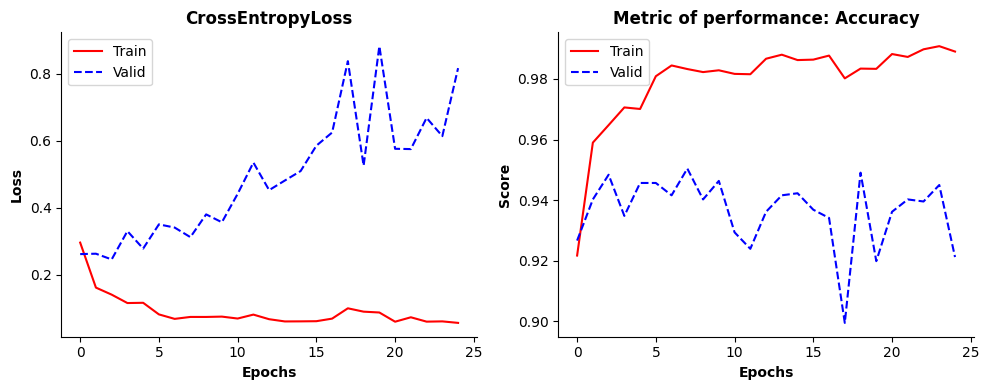

In [30]:
loss_metric_curve_plot(MODEL_RESULTS)

# Predictions

In [31]:
def predictions(test_dataloader:torch.utils.data.DataLoader):
    
    checkpoint = torch.load("/kaggle/working/best_model.pth")
    
    loaded_model = vit_b_16()
    loaded_model.heads = nn.Sequential(OrderedDict([('head',nn.Linear(in_features = 768, 
                                                                      out_features = output_shape))]))
    loaded_model.load_state_dict(checkpoint["model"])
    
    loaded_model.to(device)
    
    loaded_model.eval()
    
    y_pred_test = []
    
    with torch.inference_mode():
        for X,_ in tqdm(test_dataloader):
            X = X.to(device)
            y_pred_logit = loaded_model(X)
            y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
            y_pred_class = torch.argmax(y_pred_prob, dim = 1)
            y_pred_test.append(y_pred_class.detach().cpu())
            
    y_pred_test = torch.cat(y_pred_test)
    
    return y_pred_test

In [32]:
test_dataset = CustomImageDataset(df_test, label_map, auto_transforms)
test_dataloader = DataLoader(dataset = test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False, 
                             num_workers = NUM_WORKERS)

In [33]:
y_pred_test = predictions(test_dataloader)

  0%|          | 0/46 [00:00<?, ?it/s]

# Metrics

In [34]:
print(f'Accuracy Test = {round(accuracy_score(df_test["label"].map(label_map), y_pred_test.numpy()), 4)}')

Accuracy Test = 0.9404


In [35]:
confusion_matrix_test = confusion_matrix(df_test["label"].map(label_map), y_pred_test.numpy())

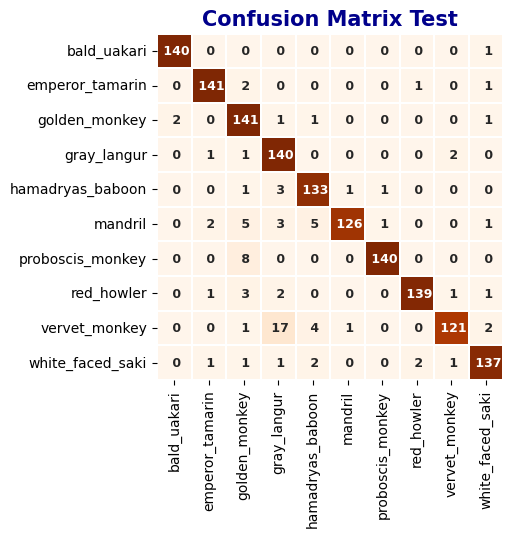

In [36]:
fig,ax = plt.subplots(figsize = (10,4.5))
sns.heatmap(confusion_matrix_test, 
            cmap = 'Oranges', 
            annot = True, 
            annot_kws = {"fontsize":9, "fontweight":"bold"}, 
            linewidths = 1.2, 
            fmt = ' ',
            linecolor = "white", 
            square = True, 
            xticklabels = classes, 
            yticklabels = classes, 
            cbar = False,
            ax = ax)
ax.set_title("Confusion Matrix Test", fontsize = 15, fontweight = "bold", color = "darkblue")
ax.tick_params('x',rotation = 90)
fig.show()